In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os
import ali.methods
import ali.ui

In [110]:
for id in os.listdir('output/my'):
        if not "P" in id :continue
        
        hr,step,rhr,info=ali.methods.load(id)
        if info['covid_test_date']:
            print(f'{id}')
#             break
        
#         alarms = pd.read_csv(f'output/my/{id}/alarm.csv',parse_dates=['datetime'],index_col='datetime').fillna(0)
#         alarms['datetime'] = pd.to_datetime(alarms['datetime'])
#         alarms = alarms.set_index('datetime')
#         if not os.path.isfile(f'output/my/{id}/rhr.h5'):
#             continue
        
#         rhr = pd.read_hdf(f'output/my/{id}/rhr.h5', 'rhr',mode='r')
        
#         display(rhr)



P476443
P851598
P261190
P111019
P214671
P992022
P477816


KeyboardInterrupt: 

In [1]:
# id='P476443'
id='P851598'
id='P261190'
id='P111019'
# id='P214671'
id='P110465'
seg='1T'

hr,step,rhr,info=ali.methods.load(id)
print(info)
ali.ui.plot(rhr,alerts=pd.DataFrame(),info=info,show=True)
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import json
import os
import compress_pickle
from sklearn.preprocessing import StandardScaler

def createAutoEncoderModel(shape):
    model = keras.Sequential(
        [
            layers.Input(shape=(shape[1], shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

    return model


def createLSTMModel(shape):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=64,
        input_shape=(shape[1], shape[2])
    ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(
        keras.layers.TimeDistributed(
            keras.layers.Dense(units=shape[2])
        )
    )
    model.compile(loss='mae', optimizer='adam')
    return model


def selectTrainTestSet(rhr, info):
    rhr=rhr.resample('1T').mean()
    if info['covid_test_date']:
        dates_s = rhr.loc[(rhr.index < info['covid_test_date'] - pd.to_timedelta('21d'))].index.floor('1D').unique()
        dates_e = list(rhr.loc[(rhr.index > info['covid_test_date'] + pd.to_timedelta('21d'))].index.floor('1D').unique())
    else:
        dates_s = rhr.index.floor('1D').unique()
        dates_e = []
        
    dates_e.append(rhr.index[-1])

    s = min(28, len(dates_s))
    e = -min(28-s, len(dates_e))-1
    train = rhr.loc[(rhr.index < dates_s[s]) | (rhr.index > dates_e[e])]
    test = rhr.loc[(rhr.index >= dates_s[s]) & (rhr.index <= dates_e[e])]

    return train, test


def preprocessing(train, test):
    # display(rhr)

    if os.path.isfile(f'ali/an_data/preprocess.pkl.lz41'):
        scaler = compress_pickle.load(f'ali/an_data/preprocess.pkl.lz4')
    else:
        scaler = StandardScaler()
        scaler = scaler.fit(train[['heartrate']])
        compress_pickle.dump(scaler, f'ali/an_data/preprocess.pkl.lz4')
    
    train = pd.DataFrame(scaler.transform(train),index=train.index,columns=train.columns)
    test = pd.DataFrame(scaler.transform(test),index=test.index,columns=test.columns)
    return train, test



def create_sequences_bad(data, resolution, seg):
    dates = data.loc[data.index.hour < 7].dropna().resample('1D').count()
    min_acceptable_count = dates.loc[dates['heartrate'] > 0].mean().values[0]/4
    data['date'] = data.index.floor('1D')
    data['time'] = data.index.time
    day_time = data.set_index(['time', 'date']).unstack(level=0).droplevel(0, axis=1).interpolate(limit_direction='both', axis=1)
    out = []
    times=[]
    for w in dates.rolling(window=f'{seg}D', closed='right'):
        if len(w) == seg:  # and w.sum().values[0]>min_acceptable_count*seg:
            res = day_time.reindex(w.index).interpolate(limit_direction='both', axis=0).values
            out.append(np.reshape(res, (res.shape[0]*res.shape[1], 1)))
            times.append(w.index[-1])
#             out.append(res)

    return np.stack(times),np.stack(out)

def create_sequences_new(data, seg, resolution='1T', min_data_count=200):
    seqs=[]
    data['id']=1

    allp2 = data.resample('1T').mean()
    allp2 = allp2.loc[allp2.index.hour<7]
    allp2['date'] = allp2.index.floor('1D')
    allp2['time'] = allp2.index.time
    day_time = allp2.set_index(['id','time', 'date']).astype(np.float64).unstack(level=1).droplevel(0, axis=1)
    day_time_info=day_time.notnull().sum(axis=1)
    display(day_time_info.mean())
    day_time_info.hist()
    day_time2=day_time.loc[day_time.notnull().sum(axis=1)>min_data_count]
    ids=day_time2.index.get_level_values(0).unique()
    
    day_time2 = day_time2.interpolate(limit_direction='both', axis=1)#.astype(np.float16)
    display(day_time2.isnull().sum().sum())
    n=0
    shape=None
    for id in ids:
        for w in day_time2.loc[id].rolling(window=f'{seg}D', closed='right'): 
            if len(w)==seg:
                n+=1
                shape=w.values.shape
    print(f'n={n} ids={len(ids)} shape={shape}')        
    out=np.zeros((n,shape[0]*shape[1],1),np.float16)
    times=[]
    i=0
    for id in ids:
      for w in day_time2.loc[id].rolling(window=f'{seg}D', closed='right'): 
        if len(w)==seg:
            out[i,:,:]=(np.reshape(w.values, (shape[0]*shape[1],1)))
            times.append(w.index[-1])
#             print(w.index)
            i+=1
    return np.stack(times),out


def create_sequences_unk(data, resolution, seg):
    time_steps = int(pd.to_timedelta('7h')/pd.to_timedelta(resolution)*seg)
    data = data.resample(resolution).mean().dropna()
#     data=data.loc[data.index.hour<7]
    values = data.values
    output = []
    times = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i: (i + time_steps)])
        times.append(data.index[(i + time_steps)-1])
    return np.stack(times),np.stack(output)





def create_sequences(data):
    resolution='1T'; seg=2
#     return create_sequences_bad(data,resolution,seg)
    return create_sequences_new(data,seg,min_data_count=200)
#     return create_sequences_unk(data,resolution,seg)
# x_train = create_sequences(train)
x_test = create_sequences(test)

# display(train)

NameError: name 'ali' is not defined

0

n=18 ids=1 shape=(2, 420)
Training input shape:  (18, 840, 1)
Epoch 1/50
1/1 [==============================] - 1s 530ms/step - loss: 1.2530 - val_loss: 0.7611
Epoch 2/50
1/1 [==============================] - 0s 23ms/step - loss: 1.2211 - val_loss: 0.7433
Epoch 3/50
1/1 [==============================] - 0s 23ms/step - loss: 1.1934 - val_loss: 0.7242
Epoch 4/50
1/1 [==============================] - 0s 23ms/step - loss: 1.1616 - val_loss: 0.7023
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 1.1296 - val_loss: 0.6767
Epoch 6/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0819 - val_loss: 0.6469
Epoch 7/50
1/1 [==============================] - 0s 23ms/step - loss: 1.0372 - val_loss: 0.6121
Epoch 8/50
1/1 [==============================] - 0s 23ms/step - loss: 0.9864 - val_loss: 0.5720
Epoch 9/50
1/1 [==============================] - 0s 24ms/step - loss: 0.9322 - val_loss: 0.5265
Epoch 10/50
1/1 [==============================] - 0s 23ms/step 

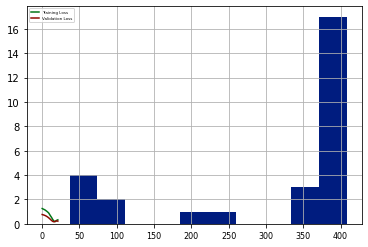

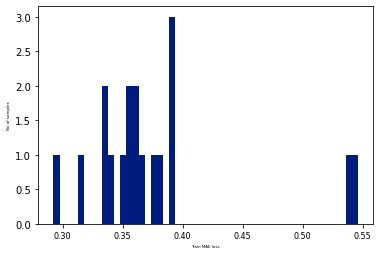

In [145]:
model='auto-encoder';
train, test = selectTrainTestSet(rhr, info)
train, test = preprocessing(train, test)

train_times,x_train = create_sequences(train)
print("Training input shape: ", x_train.shape)
if os.path.isfile(f'ali/an_data/model-{model}-{seg}.h5'):
    model = tf.keras.models.load_model(f'ali/an_data/model-{model}-{seg}.h5')
else:
    if model == 'auto-encoder':
        model = createAutoEncoderModel(x_train.shape)
    else:
        model = createLSTMModel(x_train.shape)

# model.summary()
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

Reconstruction error threshold:  0.54597634


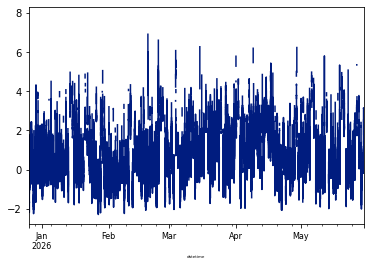

0

n=115 ids=1 shape=(2, 420)
Test input shape:  (115, 840, 1)


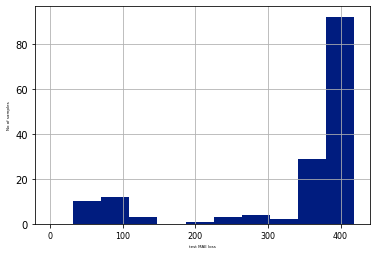

Number of anomaly samples:  12
Indices of anomaly samples:  (array([44, 45, 65, 66, 75, 78, 79, 82, 83, 84, 85, 86]),)
anomaly samples:  [Timestamp('2026-02-19 00:00:00') Timestamp('2026-02-20 00:00:00')
 Timestamp('2026-03-23 00:00:00') Timestamp('2026-03-24 00:00:00')
 Timestamp('2026-04-07 00:00:00') Timestamp('2026-04-10 00:00:00')
 Timestamp('2026-04-11 00:00:00') Timestamp('2026-04-14 00:00:00')
 Timestamp('2026-04-15 00:00:00') Timestamp('2026-04-16 00:00:00')
 Timestamp('2026-04-17 00:00:00') Timestamp('2026-04-18 00:00:00')]


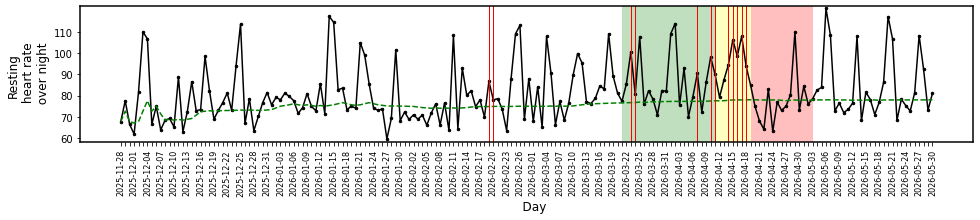

anomaly dates=12/115
from=2025-12-27 00:00:00 to=2026-05-26 00:00:00


In [146]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

fig, ax = plt.subplots()
test.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
test_times,x_test = create_sequences(test)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))
an_times=test_times[np.where(anomalies)]
print("anomaly samples: ", an_times)
an_times=pd.DataFrame(index=an_times)
an_times['anomaly']=1


dates=an_times.resample('1D').count()
# display(dates)
dates['alarm'] = (dates['anomaly']>0)*2

# return dates
ali.ui.plot(rhr,alerts=dates,info=info,show=True)
print(f'anomaly dates={sum(dates["alarm"]==2)}/{len(np.unique([p.date() for p in test_times]))}')
print(f'from={test_times[0]} to={test_times[-1]}')